### Imports

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile

### Imagem quadrada e com fundo branco

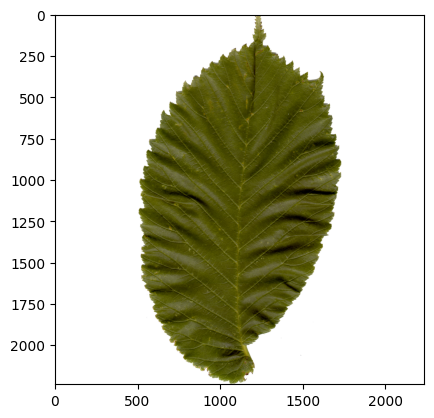

In [8]:
def preprocess_image(imagem):
    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    # Aplicar a limiarização de Otsu para obter uma imagem binarizada
    _, imagem_binaria = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    imagem_invertida = cv2.bitwise_not(imagem_binaria)
    
    # Encontrar os contornos na imagem binarizada
    contornos, _ = cv2.findContours(imagem_invertida, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Encontrar o contorno com a área máxima
    maior_contorno = max(contornos, key=cv2.contourArea)

    # Obter os quatro pontos mais extremos do contorno
    x, y, w, h = cv2.boundingRect(maior_contorno)

    # Determinar o tamanho do lado do quadrado
    tamanho_lado = max(w, h)

    # Criar a imagem RGBA (com canal alfa)
    rgba_imagem = cv2.merge([imagem, imagem_binaria])

    # Definir o canal alfa para 0 (totalmente transparente) nas regiões da folha
    rgba_imagem[imagem_binaria != 0, 0] = 255
    rgba_imagem[imagem_binaria != 0, 1] = 255
    rgba_imagem[imagem_binaria != 0, 2] = 255

    imagem_retrato = rgba_imagem[y:y+h,x:x+w, :3]

    # Calcular o preenchimento necessário para tornar a imagem quadrada
    padding_horizontal = (tamanho_lado - w) // 2
    padding_vertical = (tamanho_lado - h) // 2

    # Aplicar o preenchimento à imagem
    imagem_padded = cv2.copyMakeBorder(imagem_retrato, padding_vertical, padding_vertical, padding_horizontal, padding_horizontal, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Redimensionar a imagem para 256x256 e garantir que tenha 3 canais de cor
    imagem_final = cv2.resize(imagem_padded, (256, 256))

    return imagem_padded

img = tifffile.imread("/media/rodrigo/DATA/Documents/imagens/swedish_original/leaf01/l1nr001.tif")
nimg = preprocess_image(img)
plt.imshow(nimg)
plt.show()

### Processar todas as imagens e salvar num novo diretorio

In [9]:
# Diretório base contendo as classes
base_dir = "/home/rodrigo/Documentos/mestrado/projeto/imagens/swedish_original"

# Diretório de destino para as imagens processadas
diretorio_destino = "/home/rodrigo/Documentos/mestrado/projeto/imagens/swedish_processed"

# Lista de classes
classes = os.listdir(base_dir)

# Loop sobre as classes
for classe in classes:
    # Caminho para o diretório da classe atual
    diretorio_classe = os.path.join(base_dir, classe)

    # Caminho para o diretório de destino para a classe atual
    diretorio_destino_classe = os.path.join(diretorio_destino, classe)

    # Lista os arquivos no diretório da classe
    arquivos = os.listdir(diretorio_classe)

    # Loop sobre as imagens da classe
    for arquivo in arquivos:
        # Caminho completo para a imagem original
        caminho_imagem = os.path.join(diretorio_classe, arquivo)

        # Carrega a imagem
        imagem = tifffile.imread(caminho_imagem)

        # Tornar a imagem quadrada e com fundo branco
        imagem_processada = preprocess_image(imagem)

        # Cria o diretório de destino para a classe atual, se ainda não existir
        if not os.path.exists(diretorio_destino_classe):
            os.makedirs(diretorio_destino_classe)

        # Caminho completo para a imagem final de destino
        caminho_imagem_final = os.path.join(diretorio_destino_classe, os.path.splitext(arquivo)[0] + '.png')

        # Salva a imagem final
        cv2.imwrite(caminho_imagem_final, cv2.cvtColor(imagem_processada, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])